In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Création d'un agent générique

Nous définissons une fonction permettant de créer un agent générique.


In [2]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Définition des outils

Puis nous définissons les outils que nous souhaitons mettre à disposition de nos agents, ici la recherche internet et l'exécution de code python.

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### Le workflow sous forme d'un graphe

Nous créons un graphe portant le workflow nous permettant d'atteindre notre but.

#### State du workflow

D'abord nous définissons le `State` qui portera l'état de notre graphe tout au long de son parcours. 

Ici notre state sera simplement la liste des messages produit durant l'exécution.

In [4]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import (
    BaseMessage,
)


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

#### Les noeuds d'agent

Nous créons d'abord une fonction utilitaire générique permettant de créer des noeuds d'agent. 

In [5]:

import functools
from langchain_core.messages import ToolMessage
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


Nous créons ensuite nos 2 agents ainsi que leur noeud respectif.

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

Puis nous créons le noeud pour les outils

In [7]:

from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [9]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

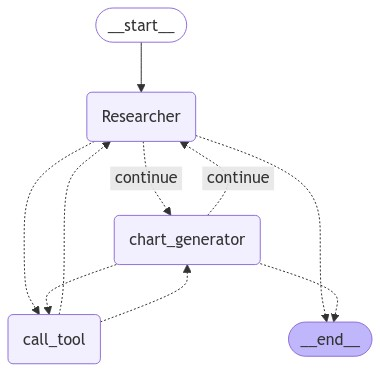

In [10]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sf1E3xGidMIGmumMUzeUDEhK', 'function': {'arguments': '{"query":"UK GDP last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 217, 'total_tokens': 240, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-2358cfc0-a0ec-4d2e-9699-a65ce75d9f61-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP last 5 years'}, 'id': 'call_sf1E3xGidMIGmumMUzeUDEhK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240, 

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_J5l2iB5L4rPEPp4iR07D7shb', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# UK GDP data for the past 5 years\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_values = [2851.41, 2697.81, 3141.51, 3088.84, 3340.03]\\n\\n# Plotting the GDP data\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Billion USD\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 175, 'prompt_tokens': 11827, 'total_tokens': 12002, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

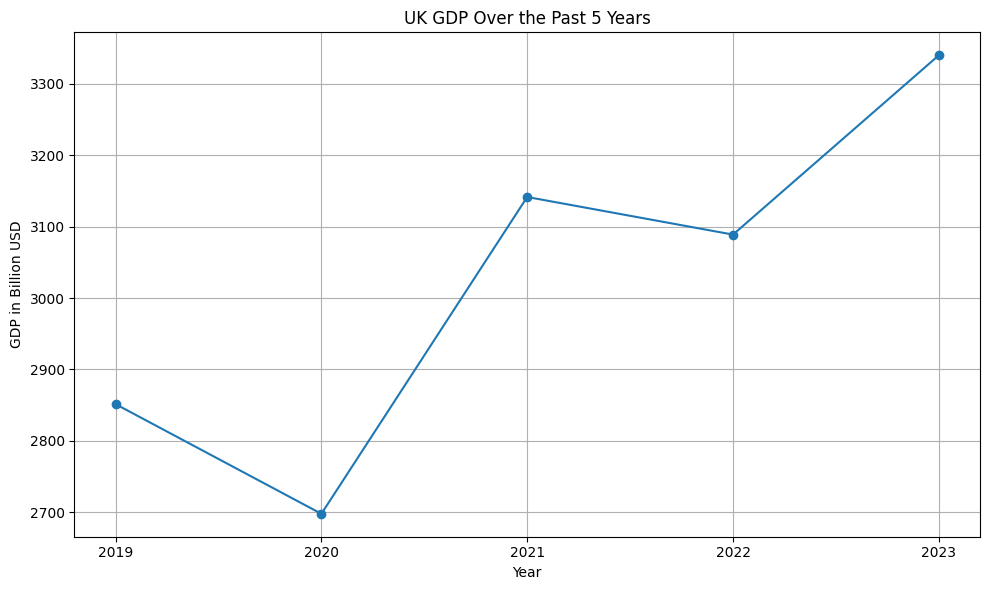

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# UK GDP data for the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [2851.41, 2697.81, 3141.51, 3088.84, 3340.03]\n\n# Plotting the GDP data\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker='o')\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\nplt.grid(True)\nplt.xticks(years)\nplt.tight_layout()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_J5l2iB5L4rPEPp4iR07D7shb')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\nThe line graph depicting the UK's GDP over the past five years has been successfully generated. You can view the graph above, showing the GDP values from 2019 to 2023 in billion USD.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'comple

In [11]:
from langchain_core.messages import HumanMessage    
import pprint
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    pprint.pprint(s)
    print("----")